In [ ]:
from shared.preface import *
import shared.functions as fct

# Halo batch parameters.
sim = 'L012N376'
snap = '0036'  # "starting" snapshot to search for halos
mass_gauge = 12.0  # in log10 Msun
mass_range = 0.46
size = 10
DM_lim_batch = 1000
CPUs_for_gravity = 4
CPUs_for_sim = 6

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(sim, snap, mass_gauge, mass_range, 'halos', size, hname)
halo_batch_IDs = np.load(f'{sim}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{sim}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

In [1]:
from shared.preface import *
import shared.functions as fct

# Load data.
nus = 10000
sim = 'L012N376'

halo_sample = 'M12'

if halo_sample == 'M11':
    mass_gauge = 11.5  # in log10 Msun
    mass_range = 0.1
    halo_num = 1
elif halo_sample == 'M12':
    mass_gauge = 12.0  # in log10 Msun
    mass_range = 0.46
    halo_num = 10

batchname = f'1e+{mass_gauge}_pm{mass_range}Msun'

mass_ticks = 100
mass_range_eV = np.geomspace(0.01, 0.3, mass_ticks)*eV  # 10 to 300 meV

n_nus_l = []
for halo_j in range(halo_num):
# for halo_j in (0,2):
# halo_j = 0

    # Load velocities.
    hname = f'{batchname}_halo{halo_j}'
    fname = f'{nus}nus_{hname}'
    u_all = fct.load_sim_data(sim, fname, 'velocities')

    # Calculate number density (averaged values for z in [z_average, 4]).
    output = f'{sim}/number_densities_{nus}nus_{hname}.npy'
    fct.number_density_1_mass(
        u_all, mass_range_eV, output, 
        average=False, m_average=0.01, z_average=3.5
    )

    nrd = np.load(f'{output}')/N0

    #note: For now, set lower limit on overdensity, s.t plot looks nicer.
    # min_val = 1 + (3*1e-3)
    # nrd[nrd <= min_val] = min_val

    n_nus_l.append(nrd)


n_nus_arr = np.array(n_nus_l).reshape(halo_num, mass_ticks)

In [ ]:
# Load data for MW halo only of smooth simulation
nus_smooth = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
sim = 'LinfNinf'
fname = f'nus_{nus_smooth}_halos_{halos}_{SOLVER}'
u_all_MW = fct.load_sim_data(sim, fname, 'velocities')

output = f'{sim}/number_densities_{fname}.npy'
fct.number_density_1_mass(
    u_all_MW, mass_range_eV, output, 
    average=True, m_average=0.1, z_average=2.0
    )
n_nus_MW = np.load(f'{output}')/N0

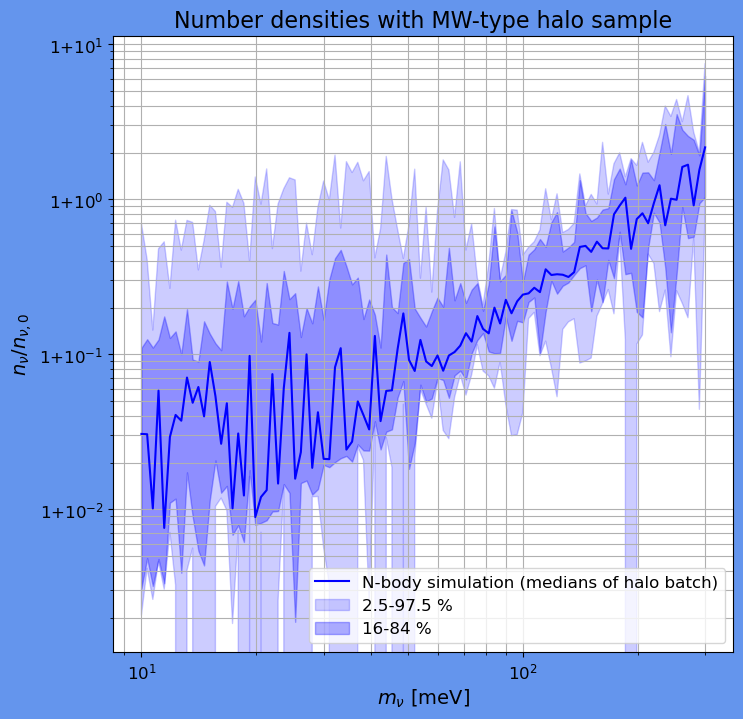

In [2]:
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('cornflowerblue')
# ax.patch.set_facecolor('lightskyblue')

# Plot smooth simulation.
# ax.plot(
#     mass_range_eV*1e3, (n_nus_MW-1), color='red', ls='solid', 
#     label='Analytical simulation'
# )

nus_median = np.median(n_nus_arr, axis=0)
nus_perc2p5 = np.percentile(n_nus_arr, q=2.5, axis=0)
nus_perc97p5 = np.percentile(n_nus_arr, q=97.5, axis=0)
nus_perc16 = np.percentile(n_nus_arr, q=16, axis=0)
nus_perc84 = np.percentile(n_nus_arr, q=84, axis=0)

# Plotting the number density median and percentiles, to create a "band".
ax.plot(
    mass_range_eV*1e3, (nus_median-1), color='blue', 
    label='N-body simulation (medians of halo batch)'
)
ax.fill_between(
    mass_range_eV*1e3, (nus_perc2p5-1), (nus_perc97p5-1), 
    color='blue', alpha=0.2, label='2.5-97.5 %')
ax.fill_between(
    mass_range_eV*1e3, (nus_perc16-1), (nus_perc84-1), 
    color='blue', alpha=0.3, label='16-84 %')


# Plot approximate values (a line) from Mertsch et al.
# x_ends = [1e1, 3*1e2]
# y_ends = [3*1e-3, 4]
# ax.plot(x_ends, y_ends, marker='x', ls=':', c='r', alpha=0.6)

# for m in NU_MASSES:
#     ax.axvline(m*1e3, c='r', ls='-.')

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_title(f'{nus}nus ; {halo_num} halos of {batchname}')
ax.set_title(f'Number densities with MW-type halo sample')  # nice title
ax.set_xlabel(r'$m_{\nu}$ [meV]')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
# ax.set_ylim(1e-3, 1e1)
plt.grid(True, which="both", ls="-")
plt.legend(loc='lower right')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))

plt.savefig(
    f'figures/number_density_band_{nus}nus_{batchname}_batch.pdf',
    facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight'
    )
plt.show()

# print('Max value:', np.max(n_nus), np.max(n_nus-1))